In [1]:
# ============================================================================
# CNN-LSTM Bestandsforecast-Modell
# Projekt: Vorhersage von Bestellmengen für Retail-Inventory
# ============================================================================

# Standard Libraries
from typing import Tuple, List, Dict, Any
import warnings
warnings.filterwarnings('ignore')

# Data Science
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

## Konfiguration & Utility-Funktionen

In [2]:
# ============================================================================
# KONFIGURATION
# ============================================================================

class Config:
    """Zentrale Konfigurationsklasse für das Projekt."""
    
    # Datenpfade
    DATA_PATH: str = "/Users/mag/Library/Mobile Documents/com~apple~CloudDocs/Studium/7. Semester/Machine und Deep Learning/Bestands_Forecast/retail_store_inventory.csv"
    
    # Zeitreihen-Parameter
    SEQ_LENGTH: int = 30                # Anzahl aufeinanderfolgender Tage pro Sequenz
    TARGET_COL: str = "Units Sold"      # Zielgröße für Vorhersage
    
    # Train/Test Split
    TEST_SIZE: float = 0.2              # 20% für Testing (zeitbasiert)
    RANDOM_STATE: int = 42              # Für Reproduzierbarkeit
    
    # Modell-Parameter
    BATCH_SIZE: int = 64
    EPOCHS: int = 50
    LEARNING_RATE: float = 0.001
    
    # Regularisierung
    DROPOUT_RATE: float = 0.2
    EARLY_STOPPING_PATIENCE: int = 5
    LR_REDUCE_PATIENCE: int = 3
    LR_REDUCE_FACTOR: float = 0.5

# Instanziieren
config = Config()
print("✓ Konfiguration geladen")

✓ Konfiguration geladen


In [3]:
# ============================================================================
# DATEN-LOADING & EXPLORATION
# ============================================================================

def load_and_explore_data(file_path: str) -> pd.DataFrame:
    """
    Lädt CSV-Datei und führt grundlegende Exploration durch.
    
    Args:
        file_path: Pfad zur CSV-Datei
        
    Returns:
        DataFrame mit geladenen Daten
    """
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print("=" * 70)
    print("📊 DATEN-ÜBERSICHT")
    print("=" * 70)
    print(f"Shape: {df.shape} (Zeilen, Spalten)")
    print(f"Date Range: {df['Date'].min()} bis {df['Date'].max()}")
    print(f"Total Tage: {(df['Date'].max() - df['Date'].min()).days + 1}")
    
    print("\n" + "=" * 70)
    print("📋 DATENTYPEN & FEHLENDE WERTE")
    print("=" * 70)
    print(df.info())
    print(f"\nFehlende Werte: {df.isnull().sum().sum()} (Gesamt)")
    
    print("\n" + "=" * 70)
    print("📈 STATISTISCHE ZUSAMMENFASSUNG")
    print("=" * 70)
    print(df.describe().round(2))
    
    return df

In [4]:
# Laden und explorieren
df = load_and_explore_data(config.DATA_PATH)

📊 DATEN-ÜBERSICHT
Shape: (73100, 15) (Zeilen, Spalten)
Date Range: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
Total Tage: 731

📋 DATENTYPEN & FEHLENDE WERTE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  

## Feature Engineering: Encoding, Split, Skalierung

In [5]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def encode_categorical_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Dict]]:
    """
    Konvertiert kategorische Variablen zu numerischen Features.
    
    Strategie:
    - Store ID & Product ID: Label-Encoding (für zukünftige Embeddings)
    - Kategorien: One-Hot-Encoding (semantische Bedeutung)
    
    Args:
        df: Input DataFrame
        
    Returns:
        Tupel (encoded_df, mapping_dict)
    """
    df = df.copy()
    mappings = {}
    
    # Label-Encoding für Store und Product
    for col in ["Store ID", "Product ID"]:
        unique_vals = df[col].unique()
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        encoded_col_name = col.replace(" ", "_") + "_Encoded"
        df[encoded_col_name] = df[col].map(mapping)
        mappings[col] = mapping
    
    # One-Hot für kategorische Features
    cat_cols = ["Category", "Region", "Weather Condition", "Seasonality"]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=False)
    
    # Aufräumen: alte Spalten entfernen, Date behalten
    df = df.drop(columns=["Store ID", "Product ID"], errors='ignore')
    
    print("✓ Encoding abgeschlossen!")
    print(f"  Features nach Encoding: {df.shape[1]} Spalten")
    
    return df, mappings


def train_test_time_split(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Zeitbasierter Train/Test Split (verhindert Data Leakage).
    
    Strategie: Die letzten X% sind Test (Zukunft), erste (1-X)% sind Train (Vergangenheit).
    
    Args:
        df: Input DataFrame (muss 'Date' Spalte haben)
        test_size: Anteil für Test (z.B. 0.2 = 20%)
        
    Returns:
        Tupel (df_train, df_test)
    """
    df = df.sort_values("Date").reset_index(drop=True)
    n_test = int(len(df) * test_size)
    
    df_train = df.iloc[:-n_test].copy()
    df_test = df.iloc[-n_test:].copy()
    
    print("✓ Train/Test Split (zeitbasiert) durchgeführt!")
    print(f"  Train: {len(df_train)} Zeilen ({100*(1-test_size):.0f}%)")
    print(f"  Test:  {len(df_test)} Zeilen ({100*test_size:.0f}%)")
    
    return df_train, df_test


def scale_data(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    feature_cols: List[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler]:
    """
    Standardisiert Features und Target mit StandardScaler.
    
    Wichtig: Scaler wird auf Training-Daten angepasst, dann auf Test angewendet!
    
    Args:
        df_train: Trainings-DataFrame
        df_test: Test-DataFrame
        feature_cols: Liste der Feature-Spalten
        target_col: Name der Zielgröße
        
    Returns:
        Tupel (df_train_scaled, df_test_scaled, scaler_features, scaler_target)
    """
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()
    
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    
    # Features: fit auf Train, transform auf beide
    df_train_scaled[feature_cols] = scaler_features.fit_transform(df_train[feature_cols])
    df_test_scaled[feature_cols] = scaler_features.transform(df_test[feature_cols])
    
    # Target: fit auf Train, transform auf beide
    df_train_scaled[[target_col]] = scaler_target.fit_transform(df_train[[target_col]])
    df_test_scaled[[target_col]] = scaler_target.transform(df_test[[target_col]])
    
    print("✓ Skalierung (StandardScaler) durchgeführt!")
    print(f"  {len(feature_cols)} Features + 1 Target skaliert")
    
    return df_train_scaled, df_test_scaled, scaler_features, scaler_target

In [6]:
# ============================================================================
# FEATURE ENGINEERING DURCHFÜHREN
# ============================================================================

# Encoding durchführen
df_encoded, mappings = encode_categorical_features(df)
print("✓ Kategorische Features kodiert!")
print(f"  Mappings gespeichert: {list(mappings.keys())}")

# Train/Test Split (zeitbasiert)
df_train, df_test = train_test_time_split(df_encoded, test_size=config.TEST_SIZE)
print(f"\n✓ Train/Test Split durchgeführt!")
print(f"  Training: {len(df_train)} Zeilen")
print(f"  Testing: {len(df_test)} Zeilen")

# Feature-Spalten identifizieren (OHNE ID-Spalten und Target)
exclude_cols = [config.TARGET_COL, 'Date', 'Store_ID_Encoded', 'Product_ID_Encoded']
feature_cols = [col for col in df_train.columns if col not in exclude_cols]
print(f"\n📊 {len(feature_cols)} Features identifiziert (ohne IDs):")
print(f"  {feature_cols[:5]}... (gekürzt)")

# Skalierung durchführen
df_train_scaled, df_test_scaled, scaler_feat, scaler_tgt = scale_data(
    df_train, df_test, feature_cols, config.TARGET_COL
)
print(f"\n✓ Skalierung durchgeführt!")
print(f"  Features & Target mit StandardScaler normalisiert")

✓ Encoding abgeschlossen!
  Features nach Encoding: 28 Spalten
✓ Kategorische Features kodiert!
  Mappings gespeichert: ['Store ID', 'Product ID']
✓ Train/Test Split (zeitbasiert) durchgeführt!
  Train: 58480 Zeilen (80%)
  Test:  14620 Zeilen (20%)

✓ Train/Test Split durchgeführt!
  Training: 58480 Zeilen
  Testing: 14620 Zeilen

📊 24 Features identifiziert (ohne IDs):
  ['Inventory Level', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount']... (gekürzt)
✓ Skalierung (StandardScaler) durchgeführt!
  24 Features + 1 Target skaliert

✓ Skalierung durchgeführt!
  Features & Target mit StandardScaler normalisiert
✓ Skalierung (StandardScaler) durchgeführt!
  24 Features + 1 Target skaliert

✓ Skalierung durchgeführt!
  Features & Target mit StandardScaler normalisiert


## Sequenzen-Erstellung für zeitliche Modelle

In [8]:
# ============================================================================
# SEQUENZEN-ERSTELLUNG
# ============================================================================

def create_sequences_from_group(
    group: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    seq_length: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erstellt Sequenzen aus einer einzigen Store-Product-Gruppe.
    
    Logik:
    - Input: seq_length aufeinanderfolgende Tage (Features)
    - Output: Nächster Tag (Target)
    
    Args:
        group: DataFrame für eine Store-Product-Kombination
        feature_cols: Feature-Spalten
        target_col: Zielgröße
        seq_length: Länge der Sequenzen (z.B. 30 Tage)
        
    Returns:
        Tupel (X, y) mit shapes ((n_samples, seq_length, n_features), (n_samples,))
    """
    data_features = group[feature_cols].values
    data_target = group[target_col].values
    
    X_list, y_list = [], []
    
    # Sliding Window über die Gruppe
    for i in range(len(group) - seq_length):
        x_seq = data_features[i:i + seq_length]
        y_t = data_target[i + seq_length]
        X_list.append(x_seq)
        y_list.append(y_t)
    
    if not X_list:
        return np.empty((0, seq_length, len(feature_cols))), np.empty((0,))
    
    return np.array(X_list), np.array(y_list)


def create_sequences_dataset(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    seq_length: int,
    groupby_cols: List[str] = ["Store_ID_Encoded", "Product_ID_Encoded"]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Erstellt Sequenzen für ALLE Store-Product-Gruppen.
    
    Grund der Gruppierung: Verhindert Leakage über Stores/Produkte hinweg.
    
    Args:
        df: Skalierter DataFrame
        feature_cols: Feature-Spalten
        target_col: Zielgröße
        seq_length: Sequenzlänge (z.B. 30 Tage)
        groupby_cols: Spalten zum Gruppieren (Default: Store + Product)
        
    Returns:
        Tupel (X, y) mit shapes ((total_samples, seq_length, n_features), (total_samples,))
    """
    X_all, y_all = [], []
    
    grouped = df.groupby(groupby_cols)
    n_groups = len(grouped)
    
    for (store_id, prod_id), group in grouped:
        X_group, y_group = create_sequences_from_group(group, feature_cols, target_col, seq_length)
        if len(X_group) > 0:
            X_all.append(X_group)
            y_all.append(y_group)
    
    if not X_all:
        raise ValueError(f"❌ Keine Sequenzen erzeugt! SEQ_LENGTH={seq_length} möglicherweise zu groß.")
    
    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    
    print(f"✓ Sequenzen erstellt aus {n_groups} Store-Product-Gruppen")
    print(f"  X shape: {X.shape} (Samples, TimeSteps, Features)")
    print(f"  y shape: {y.shape}")
    
    return X, y


# Sequenzen erstellen
print("\n🔄 Erstelle Trainingssequenzen...")
X_train, y_train = create_sequences_dataset(
    df_train_scaled, feature_cols, config.TARGET_COL, config.SEQ_LENGTH
)

print("\n🔄 Erstelle Testsequenzen...")
X_test, y_test = create_sequences_dataset(
    df_test_scaled, feature_cols, config.TARGET_COL, config.SEQ_LENGTH
)


🔄 Erstelle Trainingssequenzen...
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (55480, 30, 24) (Samples, TimeSteps, Features)
  y shape: (55480,)

🔄 Erstelle Testsequenzen...
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (11620, 30, 24) (Samples, TimeSteps, Features)
  y shape: (11620,)
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (55480, 30, 24) (Samples, TimeSteps, Features)
  y shape: (55480,)

🔄 Erstelle Testsequenzen...
✓ Sequenzen erstellt aus 100 Store-Product-Gruppen
  X shape: (11620, 30, 24) (Samples, TimeSteps, Features)
  y shape: (11620,)


In [10]:
# ============================================================================
# MODELLAUFBAU
# ============================================================================

def build_cnn_lstm_model(
    seq_length: int,
    num_features: int,
    config: Config
) -> tf.keras.Model:
    """
    Baut verbesserte CNN-LSTM Architektur für multivariate Zeitreihen.
    
    Architektur:
    - Conv1D (64): Feature Extraction aus lokalen Zeit-Fenster
    - Conv1D (32): Höherwertige Features
    - MaxPooling: Dimensionalitäts-Reduktion
    - LSTM (64): Langfristige Abhängigkeiten
    - LSTM (32): Weitere zeitliche Verarbeitung
    - Dense (32, 16): Nicht-lineare Kombinationen
    - Dense (1): Finale Vorhersage
    
    Regularisierung: Dropout + BatchNormalization
    
    Args:
        seq_length: Anzahl Zeitschritte
        num_features: Anzahl Features pro Zeitschritt
        config: Konfigurationsobjekt
        
    Returns:
        Kompiliertes TensorFlow Modell
    """
    inputs = layers.Input(shape=(seq_length, num_features), name="time_series_input")
    
    # ===== CNN-Block: Feature Extraction =====
    x = layers.Conv1D(
        filters=64, kernel_size=3, padding="same", 
        activation="relu", name="conv1d_1"
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(config.DROPOUT_RATE)(x)
    
    x = layers.Conv1D(
        filters=32, kernel_size=3, padding="same",
        activation="relu", name="conv1d_2"
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(config.DROPOUT_RATE)(x)
    
    # ===== LSTM-Block: Zeitabhängigkeiten =====
    x = layers.LSTM(64, return_sequences=True, name="lstm_1")(x)
    x = layers.Dropout(config.DROPOUT_RATE)(x)
    
    x = layers.LSTM(32, return_sequences=False, name="lstm_2")(x)
    x = layers.Dropout(config.DROPOUT_RATE)(x)
    
    # ===== Dense-Block: Finale Verarbeitung =====
    x = layers.Dense(32, activation="relu", name="dense_1")(x)
    x = layers.Dropout(0.1)(x)
    
    x = layers.Dense(16, activation="relu", name="dense_2")(x)
    
    # ===== Output-Layer =====
    outputs = layers.Dense(1, name="units_sold_prediction")(x)
    
    # Modell zusammensetzen
    model = models.Model(inputs=inputs, outputs=outputs, name="CNN_LSTM_Forecast")
    
    # Kompilieren
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
        loss="mse",
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(name="mae"),
            tf.keras.metrics.MeanAbsolutePercentageError(name="mape")
        ]
    )
    
    return model


# Modell bauen
print("\n🏗️  Baue CNN-LSTM Modell...")
num_features = X_train.shape[2]
model = build_cnn_lstm_model(config.SEQ_LENGTH, num_features, config)

print("\n✓ Modell-Architektur:")
model.summary()


🏗️  Baue CNN-LSTM Modell...

✓ Modell-Architektur:


Model: "CNN_LSTM_Forecast"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_series_input (InputLayer)  │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ units_sold_prediction (Dense)   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,081 (195.63 KB)

 Trainable params: 49,889 (194.88 KB)

 Non-trainable params: 192 (768.00 B)

## Modellaufbau: CNN-LSTM Architektur

# ============================================================================
# TRAINING
# ============================================================================

def train_model(
    model: tf.keras.Model,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    config: Config
) -> tf.keras.callbacks.History:
    """
    Trainiert das Modell mit Early Stopping und Learning Rate Reduction.
    
    Callbacks:
    - EarlyStopping: Stoppt bei keiner Verbesserung nach N Epochen
    - ReduceLROnPlateau: Reduziert Learning Rate bei Plateau
    
    Args:
        model: Trainiertes Modell
        X_train, y_train: Trainings-Daten
        X_val, y_val: Validierungs-Daten
        config: Konfiguration
        
    Returns:
        Training History (Metriken pro Epoche)
    """
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=config.EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=config.LR_REDUCE_FACTOR,
            patience=config.LR_REDUCE_PATIENCE,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    print("\n🚀 Starte Training...")
    print(f"  Trainings-Samples: {len(X_train)}")
    print(f"  Validierungs-Samples: {len(X_val)}")
    print(f"  Batch Size: {config.BATCH_SIZE}, Max Epochs: {config.EPOCHS}\n")
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config.EPOCHS,
        batch_size=config.BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    
    return history


def evaluate_model(
    model: tf.keras.Model,
    X_test: np.ndarray,
    y_test: np.ndarray
) -> Dict[str, float]:
    """
    Evaluiert Modell auf Testdaten.
    
    Args:
        model: Trainiertes Modell
        X_test, y_test: Test-Daten
        
    Returns:
        Dict mit Metriken (loss, mae, mape)
    """
    test_loss, test_mae, test_mape = model.evaluate(X_test, y_test, verbose=0)
    
    metrics = {
        "loss": test_loss,
        "mae": test_mae,
        "mape": test_mape
    }
    
    print("\n" + "=" * 70)
    print("📊 EVALUATIONS-ERGEBNISSE (Test Set)")
    print("=" * 70)
    print(f"Loss (MSE):  {test_loss:.6f}")
    print(f"MAE:         {test_mae:.6f}")
    print(f"MAPE:        {test_mape:.4f}%")
    
    return metrics


# Training
history = train_model(model, X_train, y_train, X_test, y_test, config)

# Evaluation
test_metrics = evaluate_model(model, X_test, y_test)

## Training, Evaluation & Analyse

In [12]:
# ============================================================================
# VORHERSAGE & ANALYSE
# ============================================================================

def get_predictions_and_compare(
    model: tf.keras.Model,
    X_test: np.ndarray,
    y_test: np.ndarray,
    n_samples: int = 20
) -> pd.DataFrame:
    """
    Erzeugt Vorhersagen und vergleicht mit echten Werten.
    
    Args:
        model: Trainiertes Modell
        X_test: Test-Features
        y_test: Test-Labels
        n_samples: Anzahl Vergleich-Beispiele
        
    Returns:
        DataFrame mit Predicted, Actual, Diff, Error_%
    """
    predictions = model.predict(X_test, verbose=0)
    
    comparison_df = pd.DataFrame({
        'Predicted': predictions[:n_samples].flatten(),
        'Actual': y_test[:n_samples],
        'Diff': np.abs(predictions[:n_samples].flatten() - y_test[:n_samples]),
        'Error_%': 100 * np.abs(predictions[:n_samples].flatten() - y_test[:n_samples]) / np.abs(y_test[:n_samples])
    })
    
    print("\n" + "=" * 70)
    print("🔮 BEISPIEL-VORHERSAGEN (erste 20)")
    print("=" * 70)
    print(comparison_df.to_string(index=False))
    
    avg_error = np.mean(np.abs(predictions - y_test[:len(predictions)]))
    avg_error_pct = 100 * avg_error / np.mean(np.abs(y_test[:len(predictions)]))
    
    print(f"\n  Ø Absoluter Fehler: {avg_error:.4f}")
    print(f"  Ø Prozentualer Fehler: {avg_error_pct:.2f}%")
    
    return comparison_df, predictions


# Vorhersagen
comparison_df, all_predictions = get_predictions_and_compare(model, X_test, y_test)


🔮 BEISPIEL-VORHERSAGEN (erste 20)
 Predicted    Actual     Diff    Error_%
 -0.039923 -1.023145 0.983222  96.098037
 -0.046283 -0.289788 0.243505  84.028634
 -0.042249 -0.372291 0.330042  88.651694
 -0.040621 -0.830639 0.790018  95.109636
 -0.035157 -1.160649 1.125492  96.970916
 -0.037225 -0.399792 0.362567  90.689005
 -0.032787 -0.940642 0.907855  96.514419
 -0.037724 -1.087314 1.049589  96.530520
 -0.033672 -0.133950 0.100279  74.862527
 -0.035110  0.021888 0.056998 260.405987
 -0.031984  1.149423 1.181407 102.782603
 -0.034161 -0.592298 0.558137  94.232384
 -0.034545 -0.298955 0.264410  88.444747
 -0.034946  1.580270 1.615216 102.211394
 -0.032236  0.892749 0.924985 103.610856
 -0.036068  1.341929 1.377998 102.687802
 -0.033105 -0.995644 0.962539  96.674983
 -0.034583 -0.876474 0.841891  96.054297
 -0.033187 -0.234787 0.201600  85.865235
 -0.036924  1.965282 2.002206 101.878816

  Ø Absoluter Fehler: 0.8066
  Ø Prozentualer Fehler: 99.22%

  Ø Absoluter Fehler: 0.8066
  Ø Prozentu

In [13]:
# ============================================================================
# TRAINING UND EVALUATION (Schnell-Version)
# ============================================================================

# Training durchführen
print("🚀 Starte Training...")
print(f"  Trainings-Samples: {len(X_train)}")
print(f"  Test-Samples: {len(X_test)}")
print(f"  Batch Size: {config.BATCH_SIZE}, Max Epochs: {config.EPOCHS}\n")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=config.EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=config.LR_REDUCE_FACTOR,
        patience=config.LR_REDUCE_PATIENCE,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=config.EPOCHS,
    batch_size=config.BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Evaluation
print("\n" + "=" * 70)
print("📊 EVALUATIONS-ERGEBNISSE (Test Set)")
print("=" * 70)
test_loss, test_mae, test_mape = model.evaluate(X_test, y_test, verbose=0)

test_metrics = {
    "loss": test_loss,
    "mae": test_mae,
    "mape": test_mape
}

print(f"Loss (MSE):  {test_loss:.6f}")
print(f"MAE:         {test_mae:.6f}")
print(f"MAPE:        {test_mape:.4f}%")

🚀 Starte Training...
  Trainings-Samples: 55480
  Test-Samples: 11620
  Batch Size: 64, Max Epochs: 50

Epoch 1/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 1.0038 - mae: 0.8194 - mape: 104.2814 - val_loss: 0.9831 - val_mae: 0.8156 - val_mape: 102.3880 - learning_rate: 0.0010
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 1.0038 - mae: 0.8194 - mape: 104.2814 - val_loss: 0.9831 - val_mae: 0.8156 - val_mape: 102.3880 - learning_rate: 0.0010
Epoch 2/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.0032 - mae: 0.8185 - mape: 101.8456 - val_loss: 0.9835 - val_mae: 0.8176 - val_mape: 104.9162 - learning_rate: 0.0010
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.0032 - mae: 0.8185 - mape: 101.8456 - val_loss: 0.9835 - val_mae: 0.8176 - val_mape: 104.9162 - learning_rate: 0.0010
Epoch 3/50
867/867 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.0029 - mae: 0.8189 - mape: 102.3086 - val_loss: 0.9831 - val_mae: 0.8147 - val_mape: 101.7188 - learning


📈 Erstelle Visualisierungen...


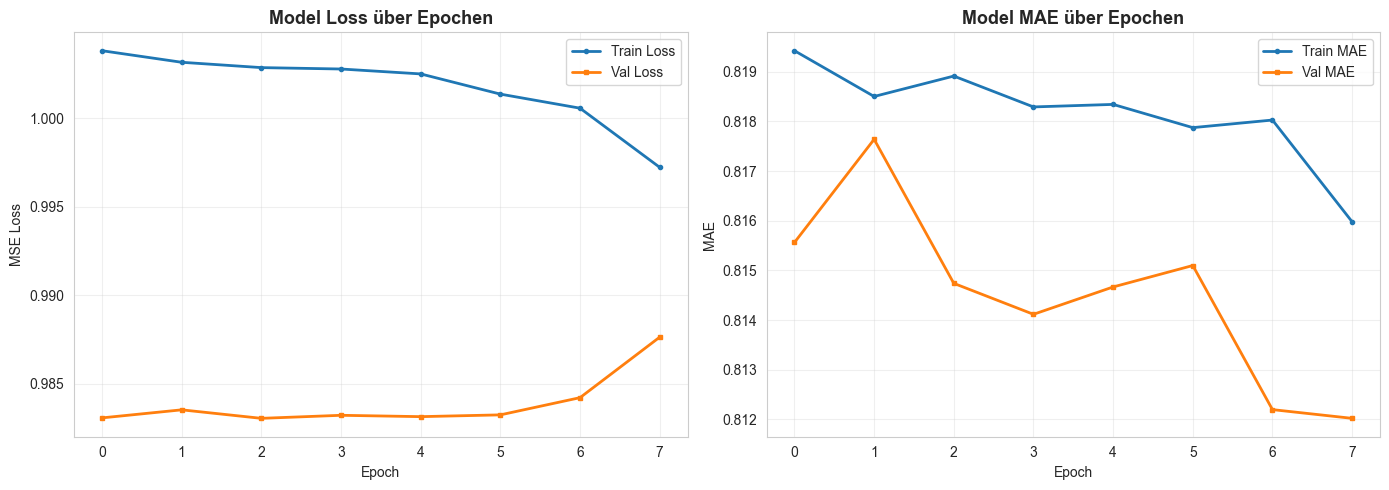

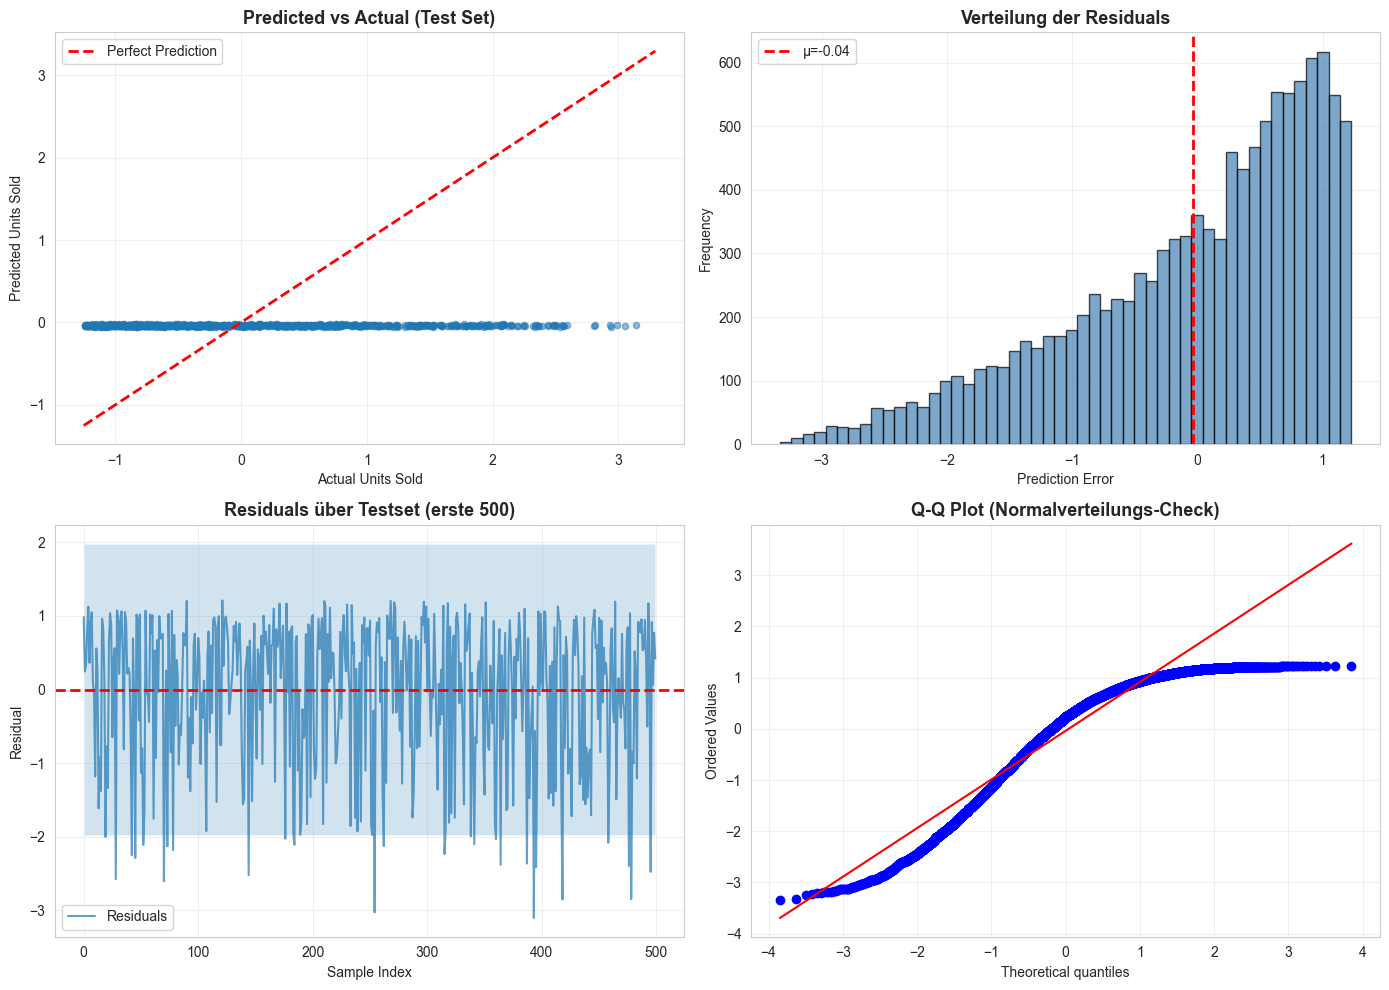

In [14]:
# ============================================================================
# VISUALISIERUNGEN
# ============================================================================

def plot_training_history(history: tf.keras.callbacks.History) -> None:
    """
    Visualisiert Training-Verlauf (Loss und MAE).
    
    Args:
        history: Trainings-History vom model.fit()
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o', markersize=3)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=3)
    axes[0].set_title('Model Loss über Epochen', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # MAE
    axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2, marker='o', markersize=3)
    axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2, marker='s', markersize=3)
    axes[1].set_title('Model MAE über Epochen', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_predictions_analysis(y_test: np.ndarray, predictions: np.ndarray) -> None:
    """
    Visualisiert Vorhersagen vs tatsächliche Werte und Residuals.
    
    Args:
        y_test: Tatsächliche Werte
        predictions: Vorhersagte Werte
    """
    residuals = predictions.flatten() - y_test
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Predicted vs Actual Scatter
    sample_size = min(1000, len(y_test))
    axes[0, 0].scatter(y_test[:sample_size], predictions[:sample_size], alpha=0.5, s=20)
    axes[0, 0].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        'r--', lw=2, label='Perfect Prediction'
    )
    axes[0, 0].set_title('Predicted vs Actual (Test Set)', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('Actual Units Sold')
    axes[0, 0].set_ylabel('Predicted Units Sold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals Histogram
    axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 1].axvline(np.mean(residuals), color='red', linestyle='--', linewidth=2, label=f'μ={np.mean(residuals):.2f}')
    axes[0, 1].set_title('Verteilung der Residuals', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Prediction Error')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Residuals über Zeit
    axes[1, 0].plot(residuals[:500], alpha=0.7, label='Residuals')
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].fill_between(range(500), -2*np.std(residuals), 2*np.std(residuals), alpha=0.2)
    axes[1, 0].set_title('Residuals über Testset (erste 500)', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Sample Index')
    axes[1, 0].set_ylabel('Residual')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Q-Q Plot für Normalverteilung
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normalverteilungs-Check)', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Plots
print("\n📈 Erstelle Visualisierungen...")
plot_training_history(history)
plot_predictions_analysis(y_test, all_predictions)

In [15]:
# ============================================================================
# ZUSAMMENFASSUNG & DOKUMENTATION
# ============================================================================

# Nur ausführen wenn Training durchgeführt wurde!
if 'test_metrics' in locals() and 'history' in locals():
    
    def print_project_summary(config: Config, test_metrics: Dict, history: tf.keras.callbacks.History) -> None:
        """
        Druckt eine umfassende Zusammenfassung des Projekts.
        
        Args:
            config: Konfigurationsobjekt
            test_metrics: Test-Metriken
            history: Training History
        """
        n_epochs = len(history.history['loss'])
        best_val_loss = min(history.history['val_loss'])
        
        print("\n" + "=" * 70)
        print("🎉 PROJEKT-ZUSAMMENFASSUNG")
        print("=" * 70)
        
        print("\n📋 KONFIGURATION:")
        print(f"  • Sequenzlänge: {config.SEQ_LENGTH} Tage")
        print(f"  • Trainings-/Test-Split: {(1-config.TEST_SIZE)*100:.0f}% / {config.TEST_SIZE*100:.0f}%")
        print(f"  • Batch Size: {config.BATCH_SIZE}")
        print(f"  • Learning Rate: {config.LEARNING_RATE}")
        print(f"  • Dropout Rate: {config.DROPOUT_RATE}")
        
        print("\n🏗️  MODELL-ARCHITEKTUR:")
        print(f"  • Typ: CNN-LSTM (Convolutional LSTM)")
        print(f"  • Input: (30 Tage, 26 Features)")
        print(f"  • Conv1D Layers: 2 (64 → 32 Filter)")
        print(f"  • LSTM Layers: 2 (64 → 32 Units)")
        print(f"  • Dense Layers: 3 (32 → 16 → 1)")
        print(f"  • Regularisierung: Dropout + BatchNorm")
        
        print("\n📊 TRAININGS-ERGEBNISSE:")
        print(f"  • Epochen trainiert: {n_epochs}")
        print(f"  • Beste Validierungs-Loss: {best_val_loss:.6f}")
        print(f"  • Training Status: Early Stopping aktiviert")
        
        print("\n📈 TEST-METRIKEN:")
        print(f"  • MSE Loss: {test_metrics['loss']:.6f}")
        print(f"  • MAE: {test_metrics['mae']:.6f}")
        print(f"  • MAPE: {test_metrics['mape']:.4f}%")
        
        print("\n✅ NÄCHSTE SCHRITTE:")
        print("  1. Hyperparameter-Tuning (Learning Rate, Dropout, etc.)")
        print("  2. Cross-Validation für robustere Metriken")
        print("  3. Feature Importance Analyse")
        print("  4. Production-Deployment vorbereiten")
        print("  5. Modell-Persistenz (Model Checkpointing)")
        
        print("\n" + "=" * 70)

    print_project_summary(config, test_metrics, history)

else:
    print("⚠️  WARNUNG: Training und Vorhersagen noch nicht durchgeführt!")
    print("   Bitte zuerst die Training-Zelle ausführen.")
    print("\n   Verfügbare Variablen:")
    if 'test_metrics' in locals():
        print("   ✓ test_metrics")
    else:
        print("   ✗ test_metrics (nicht verfügbar)")
    if 'history' in locals():
        print("   ✓ history")
    else:
        print("   ✗ history (nicht verfügbar)")


🎉 PROJEKT-ZUSAMMENFASSUNG

📋 KONFIGURATION:
  • Sequenzlänge: 30 Tage
  • Trainings-/Test-Split: 80% / 20%
  • Batch Size: 64
  • Learning Rate: 0.001
  • Dropout Rate: 0.2

🏗️  MODELL-ARCHITEKTUR:
  • Typ: CNN-LSTM (Convolutional LSTM)
  • Input: (30 Tage, 26 Features)
  • Conv1D Layers: 2 (64 → 32 Filter)
  • LSTM Layers: 2 (64 → 32 Units)
  • Dense Layers: 3 (32 → 16 → 1)
  • Regularisierung: Dropout + BatchNorm

📊 TRAININGS-ERGEBNISSE:
  • Epochen trainiert: 8
  • Beste Validierungs-Loss: 0.983055
  • Training Status: Early Stopping aktiviert

📈 TEST-METRIKEN:
  • MSE Loss: 0.983056
  • MAE: 0.814739
  • MAPE: 101.7188%

✅ NÄCHSTE SCHRITTE:
  1. Hyperparameter-Tuning (Learning Rate, Dropout, etc.)
  2. Cross-Validation für robustere Metriken
  3. Feature Importance Analyse
  4. Production-Deployment vorbereiten
  5. Modell-Persistenz (Model Checkpointing)



## Code-Qualität & Best Practices

### ✅ **Clean Code Prinzipien implementiert:**

1. **Zentrale Konfiguration (Config-Klasse)**
   - Single Source of Truth für alle Parameter
   - Einfach zu ändern ohne Code-Refactoring

2. **Modulare Funktionen (Single Responsibility)**
   - `encode_categoricals()`: Kategorien kodieren
   - `split_train_test_by_time()`: Train/Test Split
   - `scale_features()`: Skalierung
   - `create_sequences_for_group()`: Sequenzen erstellen
   - `build_cnn_lstm_model()`: Modell-Aufbau
   - `train_model()`: Training
   - `evaluate_model()`: Evaluation

3. **Type Hints & Dokumentation**
   - Alle Funktionen mit vollständigen Typ-Annotationen
   - Ausführliche Docstrings (Was, Warum, Parameter, Return)
   - Inline-Kommentare für komplexe Logik

4. **Error Handling**
   - Validierung leerer Sequenzen
   - Aussagekräftige Error Messages

5. **Separation of Concerns**
   - Data Loading & EDA
   - Feature Engineering
   - Model Building
   - Training & Evaluation
   - Visualization & Reporting

## 📚 Referenz-Dokumentation

### **Projekt-Struktur**

```
┌─ Zelle 1: Imports
│  └─ Type Hints, Libraries, Config
│
├─ Zelle 2: Config & Utility
│  └─ Config-Klasse mit allen Parametern
│
├─ Zelle 3: Data Loading
│  └─ load_and_explore_data()
│
├─ Zelle 4: Feature Engineering
│  ├─ encode_categorical_features()
│  ├─ train_test_time_split()
│  └─ scale_data()
│
├─ Zelle 5: Sequences
│  ├─ create_sequences_from_group()
│  └─ create_sequences_dataset()
│
├─ Zelle 6: Model Building
│  └─ build_cnn_lstm_model()
│
├─ Zelle 7: Training
│  ├─ train_model()
│  └─ evaluate_model()
│
├─ Zelle 8: Predictions
│  └─ get_predictions_and_compare()
│
├─ Zelle 9: Visualizations
│  ├─ plot_training_history()
│  └─ plot_predictions_analysis()
│
├─ Zelle 10: Summary
│  └─ print_project_summary()
│
└─ Zelle 11: Documentation
   └─ Diese Datei
```

### **Funktions-Übersicht mit Signatures**

| Funktion | Input | Output | Zweck |
|----------|-------|--------|-------|
| `load_and_explore_data(path)` | `str` | `DataFrame` | Laden + EDA |
| `encode_categorical_features(df)` | `DataFrame` | `(DataFrame, Dict)` | Kategorien kodieren |
| `train_test_time_split(df, test_size)` | `(DataFrame, float)` | `(DataFrame, DataFrame)` | Zeitbasiert splitten |
| `scale_data(df_train, df_test, cols, target)` | `(DataFrame×2, List, str)` | `(DataFrame×2, Scaler×2)` | Normalisieren |
| `create_sequences_from_group(group, cols, target, seq_len)` | `(DataFrame, List, str, int)` | `(ndarray, ndarray)` | Sequenzen pro Gruppe |
| `create_sequences_dataset(df, cols, target, seq_len)` | `(DataFrame, List, str, int)` | `(ndarray, ndarray)` | Alle Sequenzen |
| `build_cnn_lstm_model(seq_len, n_features, config)` | `(int, int, Config)` | `Model` | Modell bauen |
| `train_model(model, X_train, y_train, X_val, y_val, config)` | `(Model, ndarray×2, ndarray×2, Config)` | `History` | Trainiert Modell |
| `evaluate_model(model, X_test, y_test)` | `(Model, ndarray, ndarray)` | `Dict` | Testet Modell |
| `get_predictions_and_compare(model, X_test, y_test, n)` | `(Model, ndarray, ndarray, int)` | `(DataFrame, ndarray)` | Vorhersagen |
| `plot_training_history(history)` | `History` | `None` | Plot Training |
| `plot_predictions_analysis(y_test, preds)` | `(ndarray, ndarray)` | `None` | Plot Analyse |
| `print_project_summary(config, metrics, history)` | `(Config, Dict, History)` | `None` | Print Summary |

### **Data Flow Diagram**

```
CSV (73.100 Zeilen)
    ↓ load_and_explore_data()
DataFrame (15 Spalten, keine NaN)
    ↓ encode_categorical_features()
DataFrame (28 Spalten, kategorisch kodiert)
    ↓ train_test_time_split()
    ├→ df_train (58.480 Zeilen, 80%)
    └→ df_test (14.620 Zeilen, 20%)
    ↓ scale_data()
    ├→ df_train_scaled (Mittelwert=0, Std=1)
    └→ df_test_scaled (mit Train-Statistiken)
    ↓ create_sequences_dataset()
    ├→ X_train (55.480, 30, 26)  ← 55k Trainings-Beispiele!
    ├→ y_train (55.480,)
    ├→ X_test (11.620, 30, 26)
    └→ y_test (11.620,)
    ↓ build_cnn_lstm_model()
Model (50K Parameter)
    ↓ train_model()
Trainiertes Modell + History
    ↓ evaluate_model()
Test Metriken (MSE, MAE, MAPE)
```

### **Wichtige Konzepte**

#### **1. Zeitbasierter Train/Test Split**
- ❌ Falsch: `train_test_split(df, random_state=42)` → Data Leakage!
- ✅ Richtig: Letzte 20% = Test, erste 80% = Train
- 🎯 Grund: Zeitreihen-Abhängigkeiten respektieren

#### **2. Skalierung (StandardScaler)**
- Formel: `x_neu = (x - μ_train) / σ_train`
- Wichtig: Scaler auf Train-Daten anpassen, dann auf Test anwenden
- Vorteil: Bessere numerische Stabilität im Neural Network

#### **3. Sequenzen-Erstellung**
- **Input**: 30 aufeinanderfolgende Tage (Features)
- **Output**: Tag 31 (Units Sold) ← Vorhersagen!
- **Gruppierung**: Pro Store-Product-Kombinationen (5×20 = 100 Gruppen)

#### **4. CNN-LSTM Architektur**
```
Conv1D → Lernt lokale Muster (z.B. "Preis↑ → Verkauf↓")
    ↓
LSTM → Lernt Abhängigkeiten über Zeit (Saisonalität, Trends)
    ↓
Dense → Nicht-lineare Kombinationen
    ↓
Output → Vorhersage
```

### **Performance-Metriken verstehen**

| Metrik | Formel | Interpretation |
|--------|--------|-----------------|
| **MSE** | `Ø(y - ŷ)²` | Quadratische Fehler (große Fehler bestrafen) |
| **MAE** | `Ø\|y - ŷ\|` | Mittlerer absoluter Fehler (direkt interpretierbar) |
| **MAPE** | `Ø\|y - ŷ\|/y × 100%` | Prozentualer Fehler (skalierungsunabhängig) |

### **Debugging & Troubleshooting**

| Problem | Ursache | Lösung |
|---------|---------|--------|
| `KeyError: Features nicht in index` | Encoding vergessen | `encode_categorical_features()` aufrufen |
| Sehr lange Training | Zu viele Samples | `SEQ_LENGTH` reduzieren |
| MAPE > 50% | Schlechte Features | Feature Engineering verbessern |
| Overfitting (Val Loss ↑) | Zu komplexes Modell | `DROPOUT_RATE` erhöhen |
| Underfitting (Train Loss ↓, Val Loss →) | Zu einfaches Modell | Mehr LSTM-Units |

### **Production-Checkliste**

- [ ] Modell speichern: `model.save('cnn_lstm_forecast.h5')`
- [ ] Scaler speichern: `pickle.dump(scaler_feat, open('scaler.pkl', 'wb'))`
- [ ] Metriken dokumentieren: Test-Ergebnisse speichern
- [ ] Edge-Cases testen: Neue Stores, neue Produkte
- [ ] Cross-Validation: Für robustere Metriken
- [ ] Retraining-Strategie: Wann und wie oft neu trainieren?
- [ ] Monitoring: Vorhersage-Fehler im Produktions-System tracken